# Polychaete reef benthic cover and structural complexity analysis:
- Aim: Relationships between substrate type and structural complexity
- Goal: Create a complete data pipeline for data analysis and visualization
- Author: J.C. Montes-Herrera

In [1]:
## Libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import statsmodels.api as sm
#import dataframe_image as dfi
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

plt.rcParams["figure.figsize"] = (14, 6) ## Matplotlib figure size

C:\Users\jcmontes\Miniconda3\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Create dataframe with both data entries
1. Benthic cover from CoralNet
2. Structural complexity metrics from Fukunaga et al. (2019) R script

### Benthic cover metrics

In [2]:
## Create path of /Results folder
PATH_r = r"C:\Users\jcmontes\OneDrive - University of Tasmania\01_Projects_Drive\Photogrammetry\AAD2019_EF_PolychaeteReef\results"

In [3]:
## First read Benthic Cover results
os.chdir(PATH_r + '\BenthicCover')

# Read CoralNet annotations raw file
df = pd.read_csv('annotations_raw.csv')
print('Number of quadrats: ' + str(df["Name"].nunique())); print('Number of different labels: ' + str(df["Label"].nunique()))
print('Number of annotations: ' + str(len(df))); print(df.shape)
#print(df) # Visualize last 5 rows

## Create frequency table - observe new dataframe has 51 rows (quadrats) and 31 columns (labels)
df = pd.crosstab(df['Name'], df['Label'])

Number of quadrats: 51
Number of different labels: 31
Number of annotations: 7650
(7650, 4)


In [4]:
## Adjust row (quadrats) names
## This will make it easier to merge with the structural metrics (it also looks better)
df.index = df.index.str.replace(r'.jpg$', '', regex=True); df.index = df.index.str.replace(r'04-ortho__', 'A-', regex=True)
df.index = df.index.str.replace(r'05-ortho_', 'B-', regex=True); df.index = df.index.str.replace(r'06-ortho_', 'C-', regex=True)
df.index = df.index.str.replace(r'07-ortho_', 'D-', regex=True); df.index = df.index.str.replace(r'09-ortho_', 'E-', regex=True)
df.index = df.index.str.replace(r'10-ortho_', 'F-', regex=True); df.index = df.index.str.replace(r'11-ortho_', 'G-', regex=True)
df.index = df.index.str.replace(r'12-ortho_', 'H-', regex=True)
#df.head()

In [5]:
## As we are not measuring biodiversity, lets keep only substrate categories.
## This also facilitates visualization.
df = df.drop(labels = ['ANEII','ASCXI','AXIX','Cri-I','HIII','SABI','SCRO','SLIV','SLXVI',
                       'SVI','SVIII','SXIV','SXV','SXXIII','WBS','WS','ASTIV',
                       'ASTVII','OIV','OEBS','REDUID','STER','Sedturfrub'], axis = 1)

df.head()

Label,BSR,MAENG,MERCC,MERNC,SCC,SERP,SUSA,UNFO
Name,,,,,,,,
A-1_00,21,0,58,0,0,30,6,12
A-1_01,46,0,65,0,0,6,9,18
A-1_10,117,0,2,0,0,30,0,0
A-1_11,29,0,43,0,0,22,9,39
A-2_00,13,0,0,0,0,116,0,18


In [6]:
## Convert frequencies to percent cover and save DataFrame
df_benthic_cover = df.apply(lambda x: x*100/sum(x), axis=1)

### Structural complexity metrics
- Files are stored in a different folder per quadrat
- Retrieve, compile and merge with previous DataFrame (df)

In [7]:
## Notice that deep quadrats were not removed during benthic cover analysis.
## It might be better to create the dataframe and until the end plot. Lets see.
## Create a Path to the data
PATH_d = r"C:\Users\jcmontes\OneDrive - University of Tasmania\01_Projects_Drive\Photogrammetry\AAD2019_EF_PolychaeteReef\processed_data\EF-G-AggressiveFilter\EF-G-AgressiveFilter-Tiles"
dirs = glob.glob(PATH_d + '\EF*')

In [8]:
file_list = []

for subdir in dirs:
    os.chdir(subdir)
    base = os.path.basename(subdir)
    label = os.path.splitext(base)[0]
    #print(label)
    cwd = os.getcwd()
    for file in os.listdir(cwd):
        if file.endswith(".csv"):
            df = pd.read_csv(file,sep=",")
            df['file_name'] = label + "-" + df['file_name']
            file_list.append(df)

df = pd.concat(file_list, ignore_index=True).set_index('file_name')
df.head()

,orig_area,surface16,planerS16,surface32,planerS32,max_h,min_h,fd16,fd32,surface_complexity,mean_slope,mean_profile_curvature,mean_plan_curvature
file_name,,,,,,,,,,,,,
EF-G-04-DEM__1_00.tif,1.0300,5.821141,0.9216,5.821141,0.9216,30.359108,25.954962,2.224226,2.217311,6.316342,61.009223,45.803822,35.273526
EF-G-04-DEM__1_01.tif,1.0300,2.728238,0.9216,2.728238,0.9216,31.765301,30.216726,2.194972,2.201625,2.960328,47.855155,4.697123,2.477279
EF-G-04-DEM__1_10.tif,1.0403,8.701784,0.9216,8.701784,0.9216,30.384106,25.770912,2.308227,2.266483,9.442040,48.212245,108.556322,101.512511
EF-G-04-DEM__1_11.tif,1.0403,6.659451,0.9216,6.659451,0.9216,31.162127,26.774553,2.171841,2.174548,7.225967,60.925839,24.957675,27.305298
EF-G-04-DEM__2_00.tif,1.0932,2.585702,0.8448,1.759163,0.5120,20.271091,19.179802,2.295925,2.305882,3.060726,51.362519,9.367260,7.587447


In [9]:
## Adjust index to make it prettier
df.index = df.index.str.replace(r'.tif$', '', regex=True); df.index = df.index.str.replace(r'DEM__', '', regex=True)
df.index = df.index.str.replace(r'DEM_', '', regex=True); df.index = df.index.str.replace(r'EF-G-04', 'A', regex=True)
df.index = df.index.str.replace(r'EF-G-05', 'B', regex=True); df.index = df.index.str.replace(r'EF-G-06', 'C', regex=True)
df.index = df.index.str.replace(r'EF-G-07', 'D', regex=True); df.index = df.index.str.replace(r'EF-G-09', 'E', regex=True)
df.index = df.index.str.replace(r'EF-G-10', 'F', regex=True); df.index = df.index.str.replace(r'EF-G-11', 'G', regex=True)
df.index = df.index.str.replace(r'EF-G-12', 'H', regex=True)

df_structuralcomplexity = df
#df_structuralcomplexity

## Merge structural metrics and benthic cover data

In [10]:
## We have our two datasets ready to be merged.
df_habitat_metrics = pd.concat([df_structuralcomplexity, df_benthic_cover], axis=1)
#df_habitat_metrics
#df_habitat_metrics.to_csv(r"C:\Users\jcmontes\Desktop" + '/full_habitat_metrics.csv')

In [21]:
## Discard quadrats where analysis is not optimal due to survey altitude
## This has effects in benthic classification (increasing the number of Unfocused areas)
## As well as in structural metrics increasing the error (See table with scale error)
##### Re-annotate A-3_00, and last Soft Substrate ones
df_full = df_habitat_metrics.drop(['A-1_10','A-1_11','G-2_00', 'G-2_01'])

#df_full = df_full.rename({"BSR": "Broken Polychaete Tubes", "MERCC": "Crustose Coralline Algae", "MERNC":"Encrusting Red Non-Calcareous",
 #               "SCC": "Cobbles","SERP": "Polychaete Colonies", "SUSA": "Mud",'MAENG':'Green Encrusting Algae','UNFO':'Unfocused'}, 
  #             axis='columns', errors="raise")
## 47 rows
df_full
## Preliminary assesment, Nan values did not affect structural metrics correlations
#df_out_nan = df_full.dropna(axis=0)
df_full['surface_complexity'].min()

1.1489306427156

## Benthic cover percentage

In [12]:
## Rename categories, this are CoralNet labels not useful for this anymore
## New dataframe just for plotting benthic cover, in the next step we will add structural metrics to the original dataframe
df_full = df_full.rename({"BSR": "Broken Polychaete Tubes", "MERCC": "Crustose Coralline Algae", "MERNC":"Encrusting Red Non-Calcareous",
                "SCC": "Cobbles","SERP": "Polychaete Colonies", "SUSA": "Mud",'MAENG':'Green Encrusting Algae','UNFO':'Unfocused'}, 
               axis='columns', errors="raise")

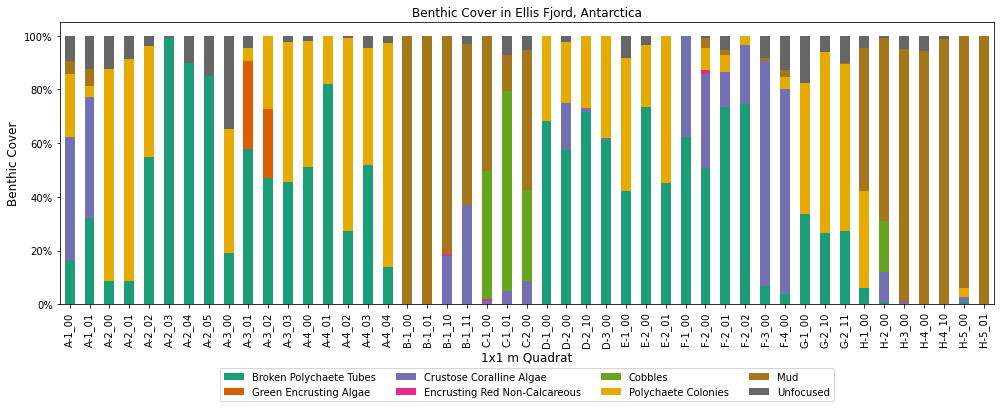

In [13]:
benthic_cover = df_full.iloc[:, -8:]

## Create plot
ax = benthic_cover.plot(kind="bar", stacked=True, title='Benthic Cover in Ellis Fjord, Antarctica', fontsize=10, cmap='Dark2') ## Bar plot
ax.set_xlabel("1x1 m Quadrat", fontdict={'fontsize':12}); ax.set_ylabel("Benthic Cover", fontdict={'fontsize':12})
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -.36),ncol = 4)
plt.tight_layout()

## Save figure in Results directory
#ax.figure.savefig(PATH_r + '/' + 'benthic-cover-plot.png')

## Habitat structural complexity

In [14]:
## P value function
from scipy.stats import pearsonr

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [15]:
## Correlation of the full dataframe that includes structural metrics and benthic cover
df_c = df_full.rename({"Broken Polychaete Tubes":"Broken-P", "Crustose Coralline Algae": "CCA", "Encrusting Red Non-Calcareous": "E-RedNC",
                       "Polychaete Colonies":"Polychaete-C",'Green Encrusting Algae':"E-Green", "surface_complexity":"Surface-C",
                       "mean_profile_curvature":"Mean-Profile-C","mean_plan_curvature":"Mean-Planar-C","fd32":"D32","fd16":"D16"}, 
               axis='columns', errors="raise")

corr_full = df_c.corr(method='pearson')

## Display only structural metrics, useful to see redundancy and select the meaningful ones
structural_metrics = corr_full.iloc[7:, 7:]
structural_metrics.style.background_gradient(cmap='coolwarm').set_precision(2)
## Save dataframe as image
#df_styled = structural_metrics.style.background_gradient(cmap='coolwarm').set_precision(2)
#dfi.export(df_styled, PATH_r + "/" + "PearsonCorrelation_Table.png")

C:\Users\jcmontes\AppData\Local\Temp/ipykernel_152/3343679172.py:11: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  structural_metrics.style.background_gradient(cmap='coolwarm').set_precision(2)


,D16,D32,Surface-C,mean_slope,Mean-Profile-C,Mean-Planar-C,Broken-P,E-Green,CCA,E-RedNC,Cobbles,Polychaete-C,Mud,Unfocused
D16,1.00,0.99,0.76,0.57,0.31,0.33,0.27,0.06,-0.37,-0.23,-0.24,0.60,-0.39,0.10
D32,0.99,1.00,0.78,0.62,0.35,0.36,0.30,0.05,-0.32,-0.25,-0.30,0.63,-0.45,0.14
Surface-C,0.76,0.78,1.00,0.77,0.64,0.62,0.30,-0.01,0.00,-0.26,-0.27,0.51,-0.54,0.17
mean_slope,0.57,0.62,0.77,1.00,0.51,0.52,0.46,-0.00,0.28,-0.24,-0.22,0.49,-0.84,0.28
Mean-Profile-C,0.31,0.35,0.64,0.51,1.00,0.98,0.21,-0.00,0.06,-0.18,-0.18,0.46,-0.50,0.20
Mean-Planar-C,0.33,0.36,0.62,0.52,0.98,1.00,0.25,-0.02,0.03,-0.18,-0.18,0.49,-0.53,0.16
Broken-P,0.27,0.30,0.30,0.46,0.21,0.25,1.00,0.13,-0.16,-0.13,-0.30,0.04,-0.66,-0.09
E-Green,0.06,0.05,-0.01,-0.00,-0.00,-0.02,0.13,1.00,-0.11,-0.06,-0.06,-0.07,-0.13,-0.08
CCA,-0.37,-0.32,0.00,0.28,0.06,0.03,-0.16,-0.11,1.00,0.12,-0.06,-0.35,-0.13,0.12
E-RedNC,-0.23,-0.25,-0.26,-0.24,-0.18,-0.18,-0.13,-0.06,0.12,1.00,0.12,-0.22,0.19,-0.17


In [16]:
df_p = calculate_pvalues(structural_metrics)
df_p

,D16,D32,Surface-C,mean_slope,Mean-Profile-C,Mean-Planar-C,Broken-P,E-Green,CCA,E-RedNC,Cobbles,Polychaete-C,Mud,Unfocused
D16,0.0,0.0,0.0,0.0009,0.0181,0.0145,0.0196,0.9046,0.0552,0.0107,0.0189,0.0,0.0053,0.3645
D32,0.0,0.0,0.0,0.0003,0.0107,0.0085,0.0138,0.92,0.0845,0.0082,0.012,0.0,0.0025,0.2932
Surface-C,0.0,0.0,0.0,0.0,0.0001,0.0001,0.0076,0.8753,0.4798,0.0049,0.009,0.0,0.0001,0.186
mean_slope,0.0009,0.0003,0.0,0.0,0.0006,0.0004,0.0017,0.9143,0.9475,0.0103,0.0175,0.0008,0.0,0.0857
Mean-Profile-C,0.0181,0.0107,0.0001,0.0006,0.0,0.0,0.037,0.7746,0.8855,0.0222,0.0429,0.0014,0.0008,0.1546
Mean-Planar-C,0.0145,0.0085,0.0001,0.0004,0.0,0.0,0.0276,0.7768,0.8121,0.0223,0.042,0.001,0.0005,0.1768
Broken-P,0.0196,0.0138,0.0076,0.0017,0.037,0.0276,0.0,0.4135,0.5121,0.0939,0.0256,0.0689,0.0002,0.7263
E-Green,0.9046,0.92,0.8753,0.9143,0.7746,0.7768,0.4135,0.0,0.4976,0.6838,0.7254,0.7859,0.7843,0.4851
CCA,0.0552,0.0845,0.4798,0.9475,0.8855,0.8121,0.5121,0.4976,0.0,0.3874,0.7757,0.1118,0.9263,0.5861
E-RedNC,0.0107,0.0082,0.0049,0.0103,0.0222,0.0223,0.0939,0.6838,0.3874,0.0,0.1117,0.0121,0.0201,0.1085


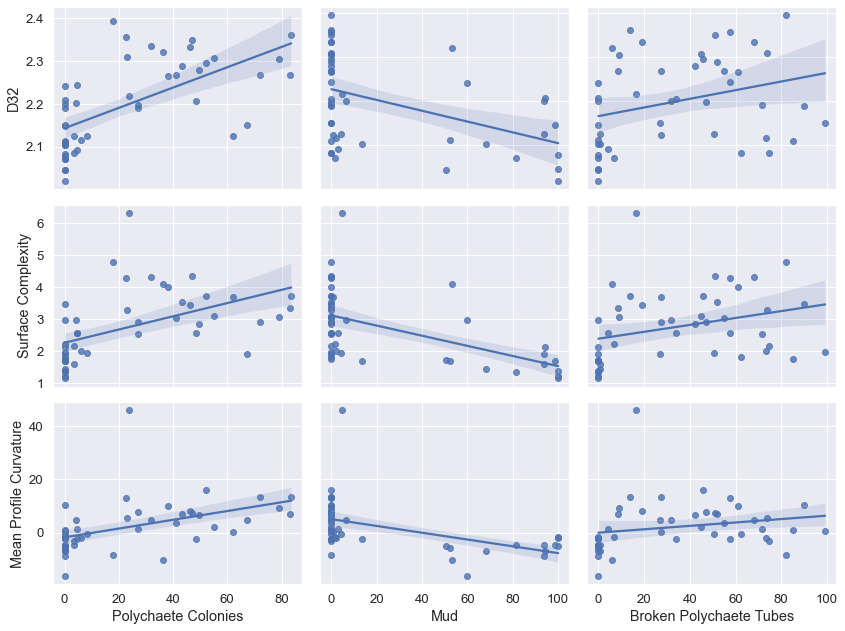

In [17]:
## Regression for main benthic cover with structural complexity metrics

sns.set(font_scale=1.2)

fig, axes = plt.subplots(3,3, sharex=False, figsize=(12,9))
## Serpulid colonies
sns.regplot(x="Polychaete Colonies", y="fd32", data=df_full, ax=axes[(0,0)], ci=95, seed = 1).set(xlabel=None, ylabel='D32', xticklabels=[])
sns.regplot(x="Polychaete Colonies", y="surface_complexity", data=df_full, ax=axes[(1,0)], ci=95, seed = 1).set(xlabel=None,ylabel='Surface Complexity', xticklabels=[])
sns.regplot(x="Polychaete Colonies", y="mean_profile_curvature", data=df_full, ax=axes[(2,0)], ci=95, seed = 1).set(ylabel='Mean Profile Curvature',)
## Coralline Algae
#sns.regplot(x="Crustose Coralline Algae", y="fd32", data=df_full, ax=axes[(0,1)], ci=95, seed = 1).set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
#sns.regplot(x="Crustose Coralline Algae", y="surface_complexity", data=df_full, ax=axes[(1,1)], ci=95, seed = 1).set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
#sns.regplot(x="Crustose Coralline Algae", y="mean_profile_curvature", data=df_full, ax=axes[(2,1)], ci=95, seed = 1).set(xlabel='Crustose Coralline Algae (CCA)',ylabel=None,yticklabels=[])
## Soft Substrate / Mud
sns.regplot(x="Mud", y="fd32", data=df_full, ax=axes[(0,1)], ci=95, seed = 1).set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
sns.regplot(x="Mud", y="surface_complexity", data=df_full, ax=axes[(1,1)], ci=95, seed = 1).set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
sns.regplot(x="Mud", y="mean_profile_curvature", data=df_full, ax=axes[(2,1)], ci=95, seed = 1).set(ylabel=None,yticklabels=[])
## Broken polychaete tubes
sns.regplot(x="Broken Polychaete Tubes", y="fd32", data=df_full, ax=axes[(0,2)], ci=95, seed = 1).set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
sns.regplot(x="Broken Polychaete Tubes", y="surface_complexity", data=df_full, ax=axes[(1,2)], ci=95, seed = 1).set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
sns.regplot(x="Broken Polychaete Tubes", y="mean_profile_curvature", data=df_full, ax=axes[(2,2)], ci=95, seed = 1).set(ylabel=None,yticklabels=[])
plt.tight_layout()

#fig.savefig(PATH_r + '/' +"linear-regression-plot.png")

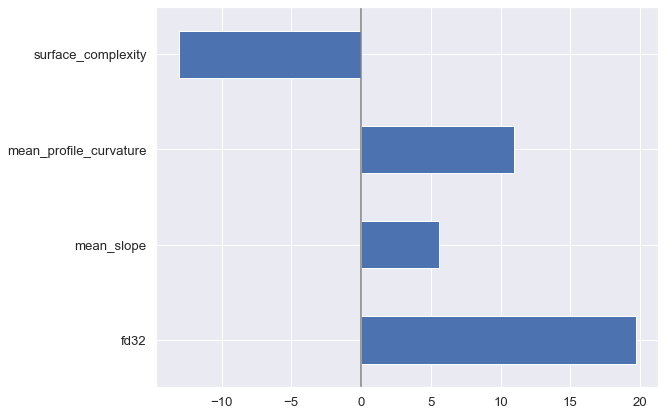

In [21]:
df = df_full.loc[:, ["Polychaete Colonies","fd32","mean_slope","mean_profile_curvature","surface_complexity"]]
target_col = "Polychaete Colonies"

X = df.loc[:, df.columns != target_col]
y = df.loc[:, target_col]

reg = LinearRegression().fit(X, y)

y_pred =  reg.predict(X)

(reg.coef_*X.std()).plot(kind="barh", figsize=(9, 7))
plt.axvline(x=0, color=".5")
#plt.tight_layout()

## Linear Regression
### Polychaete colonies

In [24]:

dataset = df_full.loc[:, ['Polychaete Colonies','fd32']]

X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

intercept = regressor.intercept_
coeff = regressor.coef_
rsq = regressor.score(X,y)

print('Intercept: ' + str(regressor.intercept_))
print('Coefficient: ' + str(regressor.coef_))
print('R-squared: ' + str(regressor.score(X,y)))

y_pred = regressor.predict(X_test)
df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Intercept: 2.1440038806135204
Coefficient: [0.00220433]
R-squared: 0.392108747677851
Mean Absolute Error: 0.04492894943934329
Mean Squared Error: 0.0026404365379696483
Root Mean Squared Error: 0.051385178193421185


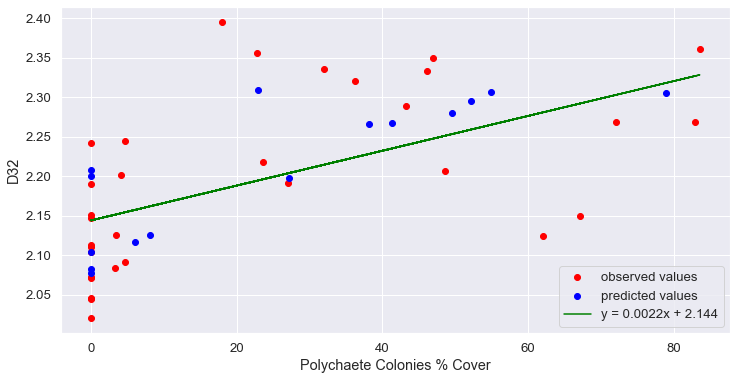

In [44]:
plt.rcParams["figure.figsize"] = (12, 6) ## Matplotlib figure size

plt.scatter(X_train, y_train, color = "red", label='observed values')
plt.scatter(X_test, y_test, color = "blue", label='predicted values')
plt.plot(X_train, regressor.predict(X_train), color = "green", label="y = 0.0022x + 2.144")
plt.xlabel("Polychaete Colonies % Cover")
plt.ylabel("D32")
plt.legend()
#plt.tight_layout()
plt.savefig(PATH_r + '/' +"model_plot_gg.png")
plt.show()

C:\Users\jcmontes\AppData\Local\Temp/ipykernel_152/1012716812.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Polychaete Colonies % Cover', pad=0.01)


0.39518176054676524


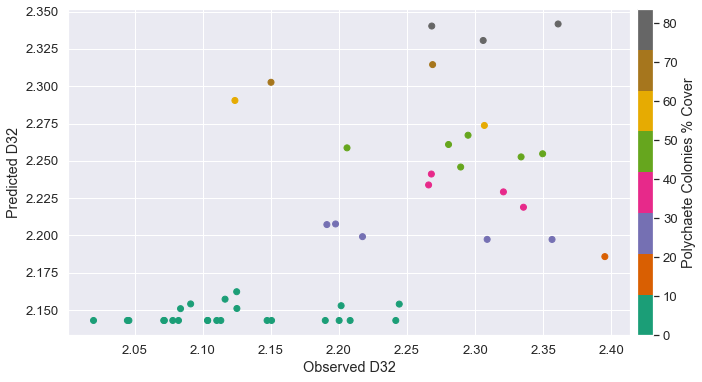

In [41]:
df = df_full.loc[:, ["Polychaete Colonies","fd32"]]
target_col = "fd32"

X = df.loc[:, df.columns != target_col]
y = df.loc[:, target_col]

#y= np.log(y+1)
reg = LinearRegression().fit(X, y)

y_pred =  reg.predict(X)

plt.scatter(y,y_pred, c=X["Polychaete Colonies"], cmap='Dark2')
plt.xlabel("Observed D32")
plt.ylabel("Predicted D32")
plt.colorbar(label='Polychaete Colonies % Cover', pad=0.01)
#plt.tight_layout()
print(reg.score(X,y))

plt.savefig(PATH_r + '/' +"obs_vs_predicted_plot_gg.png")

In [229]:
## Threshold 0.85
df = df_full.loc[:, ["Polychaete Colonies","fd32"]]
target_col = "fd32"

#df['Polychaete Colonies'] = df['Polychaete Colonies'] - df['Polychaete Colonies'].min()

X = df.loc[:, df.columns != target_col]
y = df.loc[:, target_col]

#X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   fd32   R-squared (uncentered):                   0.470
Model:                            OLS   Adj. R-squared (uncentered):              0.459
Method:                 Least Squares   F-statistic:                              40.81
Date:                Mon, 28 Mar 2022   Prob (F-statistic):                    7.56e-08
Time:                        14:52:29   Log-Likelihood:                         -88.855
No. Observations:                  47   AIC:                                      179.7
Df Residuals:                      46   BIC:                                      181.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Polychaete Colonies     0.0424      0.007      6.389      0.000       0.029       0.056
==============================================================================
Omnibus:                        6.467   Durbin-Watson:                   0.522
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                6.485
Skew:                          -0.875   Prob(JB):                       0.0391
Kurtosis:                       2.500   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

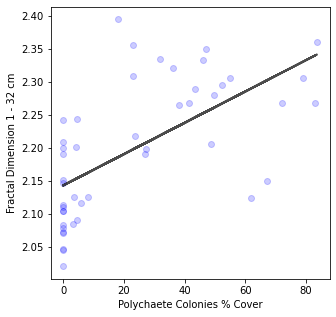

In [33]:
smOLS_int = sm.OLS(df['fd32'], sm.add_constant(df['Polychaete Colonies'])).fit()

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df["Polychaete Colonies"], df["fd32"], color='b', alpha=0.20)
ax.plot(df["Polychaete Colonies"], smOLS_int.predict(), color='black', alpha=0.70, linewidth=2) #missing legend
ax.set_xlabel('Polychaete Colonies % Cover')
ax.set_ylabel('Fractal Dimension 1 - 32 cm')
#ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.00), shadow=False, ncol=2)
plt.show()

<AxesSubplot:xlabel='Polychaete Colonies', ylabel='fd32'>

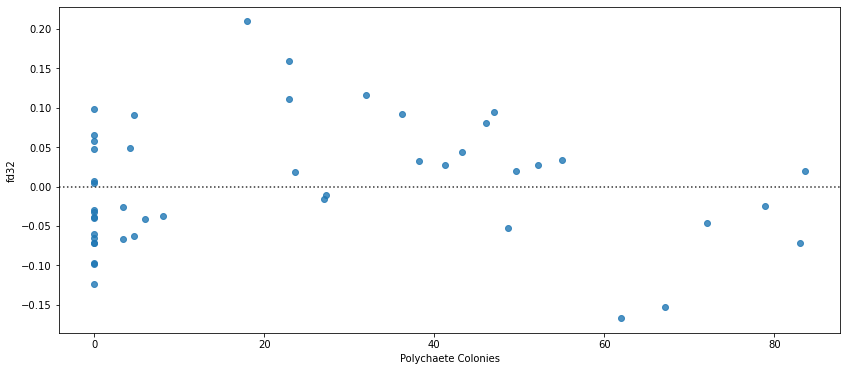

In [34]:
sns.residplot(x="Polychaete Colonies", y="fd32", data=df_full)

### Broken Polychaete tubes

In [26]:
df = df_full.loc[:, ["Broken Polychaete Tubes","mean_profile_curvature","mean_plan_curvature","fd32","mean_slope"]]
target_col = "Broken Polychaete Tubes"

df['Broken Polychaete Tubes'] = df['Broken Polychaete Tubes'] - df['Broken Polychaete Tubes'].min()

X = df.loc[:, df.columns != target_col]
y = df.loc[:, target_col]

X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Broken Polychaete Tubes   R-squared:                       0.251
Model:                                 OLS   Adj. R-squared:                  0.179
Method:                      Least Squares   F-statistic:                     3.512
Date:                     Fri, 25 Mar 2022   Prob (F-statistic):             0.0146
Time:                             12:13:15   Log-Likelihood:                -220.58
No. Observations:                       47   AIC:                             451.2
Df Residuals:                           42   BIC:                             460.4
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -33.5431    102.568     -0.327      0.745    -240.534     173.448
mean_profile_curvature    -3.2852      2.291     -1.434      0.159      -7.908       1.338
mean_plan_curvature        3.8132      2.698      1.413      0.165      -1.631       9.257
fd32                       3.7161     51.671      0.072      0.943    -100.560     107.992
mean_slope                 1.2752      0.526      2.423      0.020       0.213       2.337
==============================================================================
Omnibus:                        2.121   Durbin-Watson:                   1.236
Prob(Omnibus):                  0.346   Jarque-Bera (JB):                1.830
Skew:                           0.477   Prob(JB):                        0.400
Kurtosis:                       2.847   Cond. No.                     1.33e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

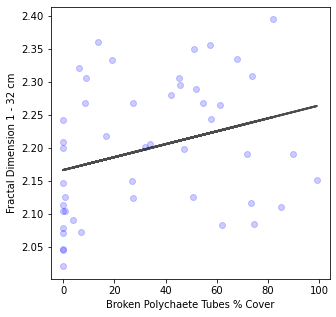

In [36]:
smOLS_int = sm.OLS(df['fd32'], sm.add_constant(df['Broken Polychaete Tubes'])).fit()

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df["Broken Polychaete Tubes"], df["fd32"], color='b', alpha=0.20)
ax.plot(df["Broken Polychaete Tubes"], smOLS_int.predict(), color='black', alpha=0.70, linewidth=2)
ax.set_xlabel('Broken Polychaete Tubes % Cover')
ax.set_ylabel('Fractal Dimension 1 - 32 cm')
#ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.00), shadow=False, ncol=2)
plt.show()

### Mud or Soft unconsolidated substrate

In [37]:
df = df_full.loc[:, ["Mud","surface_complexity","mean_profile_curvature","mean_plan_curvature","mean_slope","fd32","fd16"]]
target_col = "Mud"

df['Mud'] = df['Mud'] - df['Mud'].min()

X = df.loc[:, df.columns != target_col]
y = df.loc[:, target_col]

X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Mud   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     25.71
Date:                Thu, 24 Mar 2022   Prob (F-statistic):           2.80e-12
Time:                        14:19:19   Log-Likelihood:                -199.33
No. Observations:                  47   AIC:                             412.7
Df Residuals:                      40   BIC:                             425.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    260.2827     92.221      2.822      0.007      73.897     446.669
surface_complexity        15.3149      6.431      2.381      0.022       2.318      28.312
mean_profile_curvature     0.4764      1.760      0.271      0.788      -3.080       4.033
mean_plan_curvature       -1.6375      1.942     -0.843      0.404      -5.562       2.287
mean_slope                -3.4048      0.435     -7.819      0.000      -4.285      -2.525
fd32                    -234.4723    179.064     -1.309      0.198    -596.375     127.431
fd16                     178.4005    162.408      1.098      0.279    -149.837     506.639
==============================================================================
Omnibus:                        1.190   Durbin-Watson:                   1.364
Prob(Omnibus):                  0.552   Jarque-Bera (JB):                0.741
Skew:                           0.305   Prob(JB):                        0.690
Kurtosis:                       3.073   Cond. No.                     4.33e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.33e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

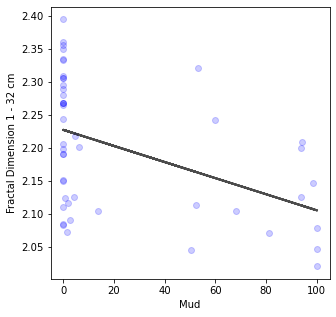

In [38]:
smOLS_int = sm.OLS(df['fd32'], sm.add_constant(df['Mud'])).fit()

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df["Mud"], df["fd32"], color='b', alpha=0.20)
ax.plot(df["Mud"], smOLS_int.predict(), color='black', alpha=0.70, linewidth=2)
ax.set_xlabel('Mud')
ax.set_ylabel('Fractal Dimension 1 - 32 cm')
#ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.00), shadow=False, ncol=2)
plt.show()

### Crustose Coralline Algae

In [39]:
df = df_full.loc[:, ["Crustose Coralline Algae","surface_complexity","mean_profile_curvature","mean_plan_curvature","mean_slope","fd32","fd16"]]
target_col = "Crustose Coralline Algae"

df['Crustose Coralline Algae'] = df['Crustose Coralline Algae'] - df['Crustose Coralline Algae'].min()

X = df.loc[:, df.columns != target_col]
y = df.loc[:, target_col]

X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     Crustose Coralline Algae   R-squared:                       0.535
Model:                                  OLS   Adj. R-squared:                  0.465
Method:                       Least Squares   F-statistic:                     7.672
Date:                      Thu, 24 Mar 2022   Prob (F-statistic):           1.60e-05
Time:                              14:19:21   Log-Likelihood:                -188.34
No. Observations:                        47   AIC:                             390.7
Df Residuals:                            40   BIC:                             403.6
Df Model:                                 6                                         
Covariance Type:                  nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    258.3729     72.990      3.540      0.001     110.854     405.892
surface_complexity         4.7944      5.090      0.942      0.352      -5.492      15.081
mean_profile_curvature     0.7264      1.393      0.522      0.605      -2.089       3.541
mean_plan_curvature       -1.3308      1.537     -0.866      0.392      -4.437       1.776
mean_slope                 1.1924      0.345      3.460      0.001       0.496       1.889
fd32                      88.6321    141.724      0.625      0.535    -197.803     375.067
fd16                    -230.6766    128.541     -1.795      0.080    -490.467      29.114
==============================================================================
Omnibus:                        4.781   Durbin-Watson:                   1.485
Prob(Omnibus):                  0.092   Jarque-Bera (JB):                5.683
Skew:                          -0.052   Prob(JB):                       0.0583
Kurtosis:                       4.700   Cond. No.                     4.33e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.33e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

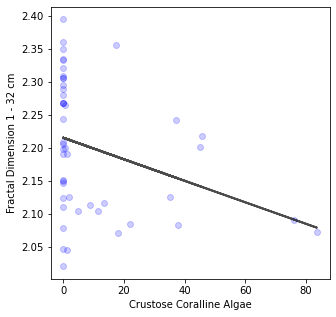

In [40]:
smOLS_int = sm.OLS(df['fd32'], sm.add_constant(df['Crustose Coralline Algae'])).fit()

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df["Crustose Coralline Algae"], df["fd32"], color='b', alpha=0.20)
ax.plot(df["Crustose Coralline Algae"], smOLS_int.predict(), color='black', alpha=0.70, linewidth=2)
ax.set_xlabel('Crustose Coralline Algae')
ax.set_ylabel('Fractal Dimension 1 - 32 cm')
#ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.00), shadow=False, ncol=2)
plt.show()

## OLS model without NaNs - not necessary now... but interesting to note the Adj. R2

In [41]:
df = df_full.loc[:, ["Polychaete Colonies","surface_complexity","mean_profile_curvature","mean_plan_curvature","mean_slope","orig_area","surface16","planerS16","surface32","planerS32","fd32"]]

In [42]:
df = df.dropna()
print(df_full.shape)
print(df.shape)

(47, 21)
(47, 11)


In [43]:
target_col = "Polychaete Colonies"

df['Polychaete Colonies'] = df['Polychaete Colonies'] - df['Polychaete Colonies'].min()

X = df.loc[:, df.columns != target_col]
y = df.loc[:, target_col]

X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Polychaete Colonies   R-squared:                       0.551
Model:                             OLS   Adj. R-squared:                  0.426
Method:                  Least Squares   F-statistic:                     4.411
Date:                 Thu, 24 Mar 2022   Prob (F-statistic):           0.000449
Time:                         14:19:23   Log-Likelihood:                -202.05
No. Observations:                   47   AIC:                             426.1
Df Residuals:                       36   BIC:                             446.5
Df Model:                           10                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -313.3235    142.139     -2.204      0.034    -601.596     -25.051
surface_complexity       -40.4088     34.656     -1.166      0.251    -110.694      29.876
mean_profile_curvature     0.3033      2.057      0.147      0.884      -3.868       4.475
mean_plan_curvature        0.8984      2.237      0.402      0.690      -3.639       5.436
mean_slope                 0.5735      0.457      1.254      0.218      -0.354       1.501
orig_area                -58.0696     69.421     -0.836      0.408    -198.863      82.724
surface16                 42.4367     55.601      0.763      0.450     -70.326     155.200
planerS16                  6.9037    187.155      0.037      0.971    -372.664     386.472
surface32                -10.4380     36.513     -0.286      0.777     -84.490      63.614
planerS32                -20.9119    119.179     -0.175      0.862    -262.617     220.794
fd32                     188.4692     61.429      3.068      0.004      63.885     313.054
==============================================================================
Omnibus:                       15.302   Durbin-Watson:                   1.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.304
Skew:                           1.162   Prob(JB):                     0.000106
Kurtosis:                       4.986   Cond. No.                     3.62e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""